In [16]:
import numpy as np 
import pandas as pd
import csv
from scipy.optimize import fsolve
import seaborn as sns
import matplotlib.pyplot as plt

import os, random
import plotly.express as px

from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
import re

import cvxpy as cp

/home/mr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [22]:
codes = pd.read_csv('/home/mr/Downloads/zip.csv')
codes.head()

,zip
0,3453
1,17459
2,5787
3,170481
4,20573


In [23]:
codes['zip'] = ((codes['zip'].astype(int)-11)/2).astype(str)

In [ ]:
import requests
import urllib.parse

zip_geo = []
for z in codes['zip'].values:
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(z) +'?format=json'

    response = requests.get(url).json()
    zip_geo += [z, response[0]["lat"], response[0]["lon"]]

In [39]:
import requests
import urllib.parse

states = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY',]
for s in states:
    address = f'{s} 170481 united states'
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

    response = requests.get(url).json()
    if len(response):
        print(s, response)

In [40]:
response[0]

IndexError: list index out of range

In [4]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()


In [3]:
def save_temporary_data_for_R(yhat1_df, yhat0_df, ps_df, A, y, file_name):
    
    n = A.shape[0]
    
    data = pd.DataFrame(columns=['A', 'y'], index=[c for c in range(n)])
    
    data['A'] = A
    data['y'] = y
    
    data.to_csv('A_y-' + file_name + '.csv', index=False)
    ps_df.to_csv('ps-' + file_name + '.csv', index=False)
    yhat1_df.to_csv('yhat1-' + file_name + '.csv', index=False)
    yhat0_df.to_csv('yhat0-' + file_name + '.csv', index=False)
        
    return

def read_temporary_data_in_R(file_name):
    
    _ = ro.r(f"A_y_data <- read.csv('A_y-{file_name}.csv')")
    _ = ro.r(f"ps_data <- read.csv('ps-{file_name}.csv')")
    _ = ro.r(f"yhat1_data <- read.csv('yhat1-{file_name}.csv')")
    _ = ro.r(f"yhat0_data <- read.csv('yhat0-{file_name}.csv')")

    _ = ro.r('A = A_y_data[, 1]')
    _ = ro.r('y = A_y_data[, 2]')
    _ = ro.r('ps = ps_data')
    _ = ro.r('yhat1 = yhat1_data')
    _ = ro.r('yhat0 = yhat0_data')
    
    return


In [4]:
# g.hat <- matrix(0, n, g.col)

# Qs = do.call(cbind, Qs)
# ps = do.call(cbind, ps)
# g.hat = cbind(Qs, ps)

def run_MR_in_R():
    _ = ro.r("""
    MREst.mean <- function(y, T, Qs, ps)
    {
        ### Important Note: T and ps in the arguments can get values of the control group (that is,
        ### if treatment=A, and its predictions are ps_t, we should set T=1-A, and ps=1-ps_t). Also,
        ### Qs are the redictions of group A which can be the treated or untreated individuals.
        
        J <- NCOL(ps)
        K <- NCOL(Qs)
        g.col <- J + K 
        n <- length(y)

        m <- sum(T) # number of observed subjects
        
        g.hat = cbind(Qs, ps)
        g.hat <- scale(g.hat, center = TRUE, scale = FALSE)[T == 1, ]# Center the predictions
        
        # define the function to be minimized
        Fn <- function(rho, ghat){ -sum(log(1 + ghat %*% rho)) }
        Grd <- function(rho, ghat){ -colSums(ghat / c(1 + ghat %*% rho)) }
        
        # calculate the weights
        rho.hat <- constrOptim(theta = rep(0, g.col), 
                             f = Fn, 
                             grad = Grd, 
                             ui = g.hat, 
                             ci = rep(1 / m - 1, m), 
                             ghat = g.hat
                             )$par
        wts <- c(1 / m / (1 + g.hat %*% rho.hat))
        normalized_wts <- wts / sum(wts)
        estimate <- sum(y[T == 1] * normalized_wts)
        return(list(estimate = estimate, weights = normalized_wts))

    }
    """)
    return
    

In [5]:
# def MR_var(y, T, normalized_wts, beta_j):
#     var = ((T*normalized_wts*y-beta_j)**2).mean()
#     return var
def MR_var0(y, 
              T, 
              u, 
              v, 
              beta1,
              beta0):
    return ((y[T==1]-beta1)**2 * u**2).sum() + ((y[T==0]-beta0)**2 * v**2).sum()

# def MR_var1(y, 
#               T, 
#               u, 
#               v, 
#               beta_hat):
#     return (((T * u - (1-T) * v) * y - beta_hat)**2).mean()

# def MR_var2(y, 
#               T, 
#               Q1,
#               Q0,
#               g,
#               beta_hat):
#     return (Q1 - Q0).var() + ((y[T==1]).var()/g[T==1]).mean() + ((y[T==0]).var()/(1-g[T==0])).mean()

# def MR_var3(y, 
#               T, 
#               u, 
#               v, 
#               beta_hat):
#     return (y[T==1]**2 * u).mean() + (y[T==0]**2 * v).mean() - beta_hat**2

# def MR_var4(y, 
#               T, 
#               u, 
#               v, 
#               beta1,
#               beta0):
#     return ((y[T==1]-beta1)**2 * u).mean() + ((y[T==0]-beta0)**2 * v).mean()

In [6]:
def MR(y, A, yhat1_df, yhat0_df, ps_df, temporary_csv_name):
    
    run_MR_in_R()
    
    save_temporary_data_for_R(yhat1_df, yhat0_df, ps_df, A, y, file_name=temporary_csv_name)
    read_temporary_data_in_R(temporary_csv_name)
    
    uuu = importr("MultiRobust")
    ro.r('library("MultiRobust")')

    ro.r('result <- MREst.mean(y=y, T=A, Qs=yhat1, ps=ps)')
    beta1 = np.array(ro.r("result$estimate"))[0]
    normalized_wts1 = np.array(ro.r("result$weights"))[0]

    ro.r('result_ <- MREst.mean(y=y, T=1-A, Qs=yhat0, ps=1-ps)')
    beta0 = np.array(ro.r("result_$estimate"))[0]
    normalized_wts0 = np.array(ro.r("result_$weights"))[0]
              
    var0 = MR_var0(y=y, 
                  T=A, 
                  u=normalized_wts1, 
                  v=normalized_wts0, 
                  beta1=beta1,
                  beta0 = beta0
                )
    
#     var1 = MR_var1(y=y, 
#                   T=A, 
#                   u=normalized_wts1, 
#                   v=normalized_wts0, 
#                   beta_hat=beta1 - beta0
#                 )
    
#     var2 = MR_var2(y=y, 
#                   T=A,  
#                   Q1=yhat1_df,
#                   Q0=yhat0_df,
#                   g=ps_df,
#                   beta_hat=beta1 - beta0
#                 )
    
#     var3 = MR_var3(y=y, 
#                   T=A, 
#                   u=normalized_wts1, 
#                   v=normalized_wts0, 
#                   beta_hat=beta1 - beta0
#                 )
    
#     var4 = MR_var4(y=y, 
#                   T=A, 
#                   u=normalized_wts1, 
#                   v=normalized_wts0, 
#                   beta1=beta1,
#                   beta0=beta0
#                 )
        
#     return beta1 - beta0, np.sqrt(var0), np.sqrt(var1), np.sqrt(var2), np.sqrt(var3), np.sqrt(var4)
    return beta1 - beta0, np.sqrt(var0)

In [7]:
def mr_bootstrap(y, A, yhat1_df, yhat0_df, ps_df, temporary_csv_name, b=1000):
    
    N = yhat1_df.shape[1]
    estimates = []
    
    for i in range(b):
        
        random_cols_yhat1 = random.choices(list(yhat1_df.columns), k=N)
        random_cols_yhat0 = random.choices(list(yhat0_df.columns), k=N)
        random_cols_ps = random.choices(list(ps_df.columns), k=N)
        
        estimates += [MR(y=y, 
                         A=A, 
                         yhat1_df=yhat1_df[random_cols_yhat1],
                         yhat0_df=yhat0_df[random_cols_yhat0], 
                         ps_df=ps_df[random_cols_ps], 
                         temporary_csv_name='temporary-MR-data')
                     ]
    estimates = pd.Series(estimates)
    
    return estimates.quantile(.025), estimates.quantile(.975), estimates.std()


In [8]:
def nIPW_var(y, 
             T, 
             g, 
             beta1,
             beta0):
    n = y.shape[0]
    var = ((((y[T==1]-beta1)/g[T==1])**2).sum() + (((y[T==0]-beta0)/(1-g[T==0]))**2).sum())/n**2
    return var

def IPW_var(y, 
             T, 
             g, 
             beta1,
             beta0):
    n = y.shape[0]
    var = (((T * y/g) - ((1-T)*y/(1-g)) - (beta1 - beta0))**2).sum()/n**2
#     var = (((T * y**2/g) - ((1-T) * y**2/(1-g)) - (beta1 - beta0)**2)).mean()/n
    
    return var

In [9]:
def nIPW(y, 
          T, 
          g):
    
    beta1 = (y[T==1]/g[T==1]).sum()
    w1 = (1/g[T==1]).sum()
    beta1 = beta1/w1
    
    beta0 = (y[T==0]/g[T==0]).sum()
    w0 = (1/g[T==0]).sum()
    beta0 = beta0/w0
    
    est = beta1 - beta0
    
    var = nIPW_var(y, T, g, beta1, beta0)
    
    return est, np.sqrt(var)

In [10]:
def naive(y, T):
    return (y * T).mean() - (y * (1-T)).mean(), 0

In [11]:
def IPW(y, 
          T, 
          g,):
    
    n = y.shape[0]
    
    beta1 = (T*y/g).mean()
    beta0 = ((1-T)*y/(1-g)).mean()
    
    est = beta1 - beta0
    
    var = IPW_var(y, T, g, beta1, beta0)
    
    return est, np.sqrt(var)

In [12]:
def AIPW(y, A, Q0, Q1, g):
    n = y.shape[0]
    
    w1 = 1. / g 
    w0 = 1. / (1 - g)

    r1 = (A * y - Q1 * (A - g)) * w1
    r0 = ((1 - A) * y + Q0 * (A - g)) * w0
    
    est = np.mean(r1) - np.mean(r0)
    
    I = (((A * y - Q1 * (A-g)) * w1 - ((1-A) * y + Q0 * (A-g))* w0) - est)
    
    var = np.dot(I.T, I)/n**2
    
    return est, np.sqrt(var)

In [13]:
def nAIPW(y, A, Q0, Q1, g):

    n = y.shape[0]
    w1 = 1. / g 
    w0 = 1. / (1 - g)

    r1 = A * (y - Q1) * w1
    r0 = (1 - A) * (y - Q0) * w0
    
    s1 = np.sum(r1)/np.sum(A * w1)
    s0 = np.sum(r0)/np.sum((1-A) * w0)
    
    SR_est = Q1.mean() - Q0.mean()
    nDR_est = (s1 - s0) + SR_est

    # I = (((A * (y - Q1)) * w1/np.sum(A * w1) - ((1-A) * (y - Q0) )* w0/np.sum((1-A) * w0)) + (SR_est - nDR_est)/n).reshape(-1, 1)    
    I = (((A * (y - Q1)) * w1/np.sum(A * w1) - ((1-A) * (y - Q0) )* w0/np.sum((1-A) * w0)) + (SR_est - nDR_est)/n)   
    
    var = np.dot(I.T, I)
    
    return nDR_est, np.sqrt(var)

In [14]:
temp_results1 = []

r3 = 0.01
r4 = 0.01
r1, r2 = 0, 0

nonlin_portion = .3
True_TE = 1

mr_estimates = []

for n, p in [(750, 32), (7500, 300)]:
        
    for niter in range(1, 101):
        try:
#         if True:
            filename = "/home/mr/PhD/Causality in AI/Sim2022/featureImp_dim{}_{}_r_{}_{}/KfoldQ_ps_nns{}.csv"\
                                                                    .format(n, p, r3, r4, niter)

            data = pd.read_csv(filename)

            naive_oracle_only, se_naive_oracle_only = naive(y=data['y'], 
                                                           T=data['A']
                                                         )
            
            IPW_oracle_only, se_IPW_oracle_only = IPW(y=data['y'], 
                                                          T=data['A'], 
                                                          g=data['ps_oracle']
                                                         )
            nIPW_oracle_only, se_nIPW_oracle_only = nIPW(y=data['y'], 
                                                          T=data['A'], 
                                                          g=data['ps_oracle']
                                                         )
            
            
            AIPW_oracle_only, se_AIPW_oracle_only = AIPW(y=data['y'], 
                                                          A=data['A'], 
                                                          Q1 = data['oracle_yhat1'],
                                                          Q0 = data['oracle_yhat0'],
                                                          g=data['ps_oracle']
                                                         )
            nAIPW_oracle_only, se_nAIPW_oracle_only = nAIPW(y=data['y'], 
                                                          A=data['A'], 
                                                          Q1 = data['oracle_yhat1'],
                                                          Q0 = data['oracle_yhat0'],
                                                          g=data['ps_oracle']
                                                         )
            
            mr_estimates += [(n, p, r3, r4, niter, 
                              naive_oracle_only, se_naive_oracle_only,
                              IPW_oracle_only, se_IPW_oracle_only,
                              nIPW_oracle_only, se_nIPW_oracle_only,
                              AIPW_oracle_only, se_AIPW_oracle_only,
                              nAIPW_oracle_only, se_nAIPW_oracle_only,
                             )]
        except:
            print(filename)

mr_estimates_nIPW = pd.DataFrame(mr_estimates,
                            columns = [
                                        'n', 'p', 'r3', 'r4', 'niter', 
                                        'naive_oracle_only', 'se_naive_oracle_only',
                                        'IPW_oracle_only', 'se_IPW_oracle_only',
                                        'nIPW_oracle_only', 'se_nIPW_oracle_only',
                                        'AIPW_oracle_only', 'se_AIPW_oracle_only',
                                        'nAIPW_oracle_only', 'se_nAIPW_oracle_only',
                                    ]
                           )
mr_estimates_nIPW.head()

,n,p,r3,r4,niter,naive_oracle_only,se_naive_oracle_only,IPW_oracle_only,se_IPW_oracle_only,nIPW_oracle_only,se_nIPW_oracle_only,AIPW_oracle_only,se_AIPW_oracle_only,nAIPW_oracle_only,se_nAIPW_oracle_only
0,750,32,0.01,0.01,1,0.597434,0,1.072028,0.132184,1.074442,0.071117,1.068384,0.071563,1.068422,0.071292
1,750,32,0.01,0.01,2,0.504450,0,1.130182,0.131143,1.113204,0.073111,1.105327,0.074091,1.105530,0.073609
2,750,32,0.01,0.01,3,0.469689,0,0.987241,0.136292,0.983411,0.072870,0.987426,0.073329,0.987153,0.072557
3,750,32,0.01,0.01,4,0.521065,0,0.971177,0.137942,0.949435,0.073613,0.954722,0.074469,0.954700,0.073053
4,750,32,0.01,0.01,5,0.498870,0,1.078478,0.134155,1.078914,0.072678,1.060621,0.072379,1.060592,0.071413


In [28]:
est_ = 'nIPW'


import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    shared_xaxes=True,
    vertical_spacing=0.06,
    subplot_titles=('n=750, p=32', 'n=7500, p=300'
                   ),
)
# mr_estimates_nIPW = mr_estimates_nIPW[]
n750 = mr_estimates_nIPW[mr_estimates_nIPW['n']==750]
n7500 = mr_estimates_nIPW[mr_estimates_nIPW['n']==7500]



fig.add_trace(
    go.Scatter(
                x=[f'{est_}'],
                y=[1],
                line_color='red', showlegend=True, name=f'True effect'
            ),
    row=1, col=1,
)
#####
fig.add_trace(
    go.Box(
                y=n750[f'{est_}_oracle_only'],
                name=f'{est_}',
                marker_color='blue',
                showlegend=True
),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(
                x=[f'{est_}'],
                y=[1],
                line_color='red', showlegend=False, name=f'True effect'
            ),
    row=1, col=2,
)
#####
fig.add_trace(
    go.Box(
                y=n7500[f'{est_}_oracle_only'],
                name=f'{est_}',
                marker_color='blue',
                showlegend=False
),
    row=1, col=2,
)

fig.add_trace(
    go.Scatter(
                x=[f'{est_}'],
                y=[n750[f'{est_}_oracle_only'].std()],
                line_color='black', showlegend=True, name=f'True {est_}-MC std'
            ),
    row=2, col=1,
)
#####
fig.add_trace(
    go.Box(
                y=n750[f'se_{est_}_oracle_only'],
                name=f'{est_}',
                marker_color='cyan',
                showlegend=True
),
    row=2, col=1,
)

fig.add_trace(
    go.Scatter(
                x=[f'{est_}'],
                y=[n7500[f'{est_}_oracle_only'].std()],
                line_color='black', showlegend=False, name=f'True {est_}'
            ),
    row=2, col=2,
)
#####
fig.add_trace(
    go.Box(
                y=n7500[f'se_{est_}_oracle_only'],
                name=f'{est_}',
                marker_color='cyan',
                showlegend=False
),
    row=2, col=2,
)


fig.update_layout(height=600, width=750,
                  yaxis = {'title': 'Estimator Dist.'},
                  yaxis3 = {'title': 'Stderr Dist.'},
                  title=f'{est_}'
                 )

fig.write_image(f"/home/mr/Pictures/sims/low-conf-{est_}-asympt-std.pdf")

fig.show()

In [ ]:
# valid to use nIPW for MR, is it useful, I present the results. Increase of dimensionality ruins the variance
# The bias ins of the magnitude of ..., 

In [9]:
temp_results1 = []

r3 = 0.25
r4 = 0.25
r1, r2 = 0, 0

nonlin_portion = .3
True_TE = 1

mr_estimates = []

for n, p in [(750, 32), (7500, 300)]:
        
    for niter in range(1, 101):
#         try:
        if True:
            filename = "/home/mr/PhD/Causality in AI/Sim2021/featureImp_dim{}_{}_r_{}_{}/KfoldQ_ps_nns{}.csv"\
                                                                    .format(n, p, r3, r4, niter)

            data = pd.read_csv(filename)
            
        break
    break

In [14]:
old = ['farrell2018deep','brookhart2006variable','robins1994estimationa','shen2022consistency','fawcett2006introduction','rubin1974estimating','huang2015regularization','schmidt2013comparative','Busso2014New','hernan2014inverse','robins2000margins','hernan2006estimators','bang2005doubly','van2003unified','cole2010constructing','sloczynski2018general','hahn2004functional','hahn1998role','smucler2019unifying','zhang2021understanding','macdorman1998infant','glmnet','kingma2014adam','macdorman1999infant','hines2021demystifying','polley2007super','wang2019multiple','mathews1998infant','schneeweiss2009high','flores2009evaluating','feng2012generalized','peysakhovich2016combining','hartford2016counterfactual','johnson2016mimic','nguyen2016control','grzegorczyk2019vector','rapoport2003length','horvitz1952generalization','yoon2018ganite','schwab2018perfect','alaa2017deep','ramachandra2018deep','lu2018estimating','ratkovic2017causal','robinson1988root','belloni2014inference','alaa2018bayesian','rosenbaum1985constructing','foster2011subgroup','2018_CausalBenchmark','imai2013estimating','pearl1995causal','glynn2010introduction','setoguchi2008evaluating','pearl2011invited','myers2011effects','glymour2008methodological','vanderweele2011new','zhou2018variance','schuster2016propensity','fithian2014optimal','karim2017estimating','van2006targeted','rubin2007design','robins1994estimationregression','bang2005doubly','westreich2010propensity','hill2011bayesian','taddy2016nonparametric','egami2018make','wager2018estimation','athey2016recursive','shimoni2018benchmarking','ruder2017overview','baxter1997bayesian','shi2019adapting','belloni2012sparse','li2017causal','dorie2019automated','rubin1979using','gruber2011tmle','farrell2015robust','seaman2018introduction','greenland1999confounding','scharfstein1999adjusting','sturmer2006insights','funk2011doubly','kang2007demystifying','scikit-learn','van2007causal','szekely2007measuring','rubin2006affinely','shortreed2017outcome','tian2018selective','ertefaie2018variable','patrick2011implications','diaz2018doubly','lunceford2004stratification','politis1994stationary','stefanski2002calculus','sloczynski2014general','cao2009improving','tan2007comment','de2011covariate','rosenbaum1983central','busso2014new','kern2016assessing','margossian2018review','hardle1989investigating','imbens2000role','rosenbaum1984reducing','rubin1976multivariate','stuart2010matching','cheng2018polynomial','xu2015empirical','cochran1973controlling','yan2020h','moosavi2021costs','chernozhukov2020adversarial','chernozhukov2022automatic','rostami2022normalized','van2007super','friedman2001greedy','martens2006instrumental','bascle2008controlling','hernan2006instruments','angrist2001instrumental','petersen2012diagnosing','hornik1989multilayer','srivastava2014dropout','rothenhausler2020model','naik2016multiply','han2014multiply','heckman1998matching','rostami2022targeted','han2013estimation','empiricaldist','wang2009empirical','owen1988empirical','hogg1995introduction','robins2000robins','hernan2006a','bang2005bang','vanderlaan2003der','cole2010cole','bang2005bang','cole2010cole','li2013li','hernan2014a','zhang2015zhang','bang2005bang','imai2004imai','Chen2019A','shortreed2017outcome','li2018li','li2019li','dong2020dong','li2020ali','jiang2020jiang','chen2019chen','li2020bli','zou2020feature','zhu2020a','zeng2018a','hirano2003efficient','imbens1994identification','bjorklund1987the','heckman1997instrumental','heckman1999local','heckman2000astructural','baron1986the','bound1995problems','chernozhukov2006instrumental','bound1995problems','thistlethwaite1960regression','hansen1982large','chernozhukov2006instrumental','glynn2010an','zhang2015on','li2013sensitivity','cole2010constructing','zhang2015adaptive',]
new = ['brookhart2006variable','rothenhausler2020model','naik2016multiply','han2014multiply','heckman1998matching','rostami2022targeted','han2013estimation','rostami2022normalized','glmnet','kingma2014adam','polley2007super','mathews1998infant','schneeweiss2009high','flores2009evaluating','feng2012generalized','peysakhovich2016combining','hartford2016counterfactual','johnson2016mimic','nguyen2016control','grzegorczyk2019vector','rapoport2003length','horvitz1952generalization','yoon2018ganite','stefanski2002calculus','chernozhukov2020adversarial','robinson1988root','chernozhukov2022automatic','schwab2018perfect','alaa2017deep','ramachandra2018deep','lu2018estimating','ratkovic2017causal','robinson1988root','belloni2014inference','alaa2018bayesian','rosenbaum1985constructing','foster2011subgroup','2018_CausalBenchmark','imai2013estimating','setoguchi2008evaluating','pearl2011invited','myers2011effects','glymour2008methodological','vanderweele2011new','zhou2018variance','schuster2016propensity','fithian2014optimal','karim2017estimating','van2006targeted','rubin2007design','rubin2007design','robins1994estimation','bang2005doubly','westreich2010propensity','hill2011bayesian','taddy2016nonparametric','egami2018make','wager2018estimation','athey2016recursive','hill2011bayesian','shimoni2018benchmarking','ruder2017overview','van2007super','baxter1997bayesian','wang2019multiple','empiricaldist','wang2009empirical','owen1988empirical','shi2019adapting','belloni2012sparse','li2017causal','dorie2019automated','lunceford2004stratification','rubin1979using','gruber2011tmle','friedman2001greedy','martens2006instrumental','bascle2008controlling','hernan2006instruments','angrist2001instrumental','seaman2018introduction','greenland1999confounding','sturmer2006insights','funk2011doubly','kang2007demystifying','farrell2018deep','learn','van2007causal','szekely2007measuring','rubin2006affinely','shortreed2017outcome','tian2018selective','ertefaie2018variable','patrick2011implications','de2011covariate','rosenbaum1983central','hogg1995introduction','kern2016assessing','margossian2018review','hardle1989investigating','van2007super','imbens2000role','rosenbaum1984reducing','rubin1976multivariate','petersen2012diagnosing','stuart2010matching','cochran1973controlling',]
[c for c in new if c not in old]

['robins1994estimation', 'learn']

In [16]:
temp_results1 = []

r3 = 0.01
r4 = 0.01
r1, r2 = 0, 0

nonlin_portion = .3
True_TE = 1

mr_estimates = []

for n, p in [(750, 32), (7500, 300)]:
        
    for niter in range(1, 101):
#         try:
        if True:
            filename = "/home/mr/PhD/Causality in AI/Sim2022/featureImp_dim{}_{}_r_{}_{}/KfoldQ_ps_nns{}.csv"\
                                                                    .format(n, p, r3, r4, niter)

            data = pd.read_csv(filename)
            
            yhat0_cols = [c for c in data.columns if ('nnY' in c or 'nnAY' in c) and 'yhat0' in c and 'oracle' not in c]
            yhat1_cols = [c for c in data.columns if ('nnY' in c or 'nnAY' in c) and 'yhat1' in c and 'oracle' not in c]
            ps_cols = [c for c in data.columns if ('nnA_' in c or 'nnAY' in c) and 'ps_' in c and 'oracle' not in c]

            (mr_oracle_only, 
            se0_mr_oracle_only) = \
                          MR(y=data['y'], 
                               A=data['A'], 
                                   yhat1_df=data[['oracle_yhat1']],
                                   yhat0_df=data[['oracle_yhat0']],
                                   ps_df=data[['ps_oracle']], 
                               temporary_csv_name='temporary-MR-data-with_oracle'
                             )
            
            mr_estimates += [[n, p, r3, r4, niter, 
                              
                              mr_oracle_only,
                              se0_mr_oracle_only,
#                               se1_mr_oracle_only,
#                               se2_mr_oracle_only,
#                               se3_mr_oracle_only,
#                               se4_mr_oracle_only,
                             ]]           

#         except Exception as e:
#             print(e)

mr_estimates3_experiment = pd.DataFrame(mr_estimates,
                            columns = [
                                        'n', 'p', 'r3', 'r4', 'niter', 

                                        'mr_oracle_only',
                                        'se0_mr_oracle_only',
#                                         'se1_mr_oracle_only',
#                                         'se2_mr_oracle_only',
#                                         'se3_mr_oracle_only',
#                                         'se4_mr_oracle_only',
                                              ]
                           )


In [17]:
1

1

In [18]:
MR_oracle_only_MCstd = mr_estimates3_experiment.groupby(['n', 'p']).std()[['mr_oracle_only']]
MR_oracle_only_avg_se = mr_estimates3_experiment.groupby(['n', 'p']).mean()[['se0_mr_oracle_only']]
MR_oracle_only_std_se = mr_estimates3_experiment.groupby(['n', 'p']).std()[['se0_mr_oracle_only']]
MR_oracle_only_std_se.columns = [c+'_std' for c in MR_oracle_only_std_se.columns]
MR_oracle_only = MR_oracle_only_MCstd.join(MR_oracle_only_avg_se).join(MR_oracle_only_std_se)
for c in ['se0_mr_oracle_only']:
    MR_oracle_only['L_'+c] = MR_oracle_only[c] - 1.96 * MR_oracle_only[c+'_std']
    MR_oracle_only['U_'+c] = MR_oracle_only[c] + 1.96 * MR_oracle_only[c+'_std']
MR_oracle_only[['mr_oracle_only']+['L_se0_mr_oracle_only', 'U_se0_mr_oracle_only']]

,,mr_oracle_only,L_se0_mr_oracle_only,U_se0_mr_oracle_only
n,p,,,
750,32,0.074564,0.066601,0.079974
7500,300,0.025974,0.022464,0.023692


In [26]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    shared_xaxes=True,
    vertical_spacing=0.06,
    subplot_titles=('n=750, p=32', 'n=7500, p=300'
                   ),
)

n750 = mr_estimates3_experiment[mr_estimates3_experiment['n']==750]
n7500 = mr_estimates3_experiment[mr_estimates3_experiment['n']==7500]

n750 = n750[n750['se0_mr_oracle_only']<2]
n7500 = n7500[n7500['se0_mr_oracle_only']<2]


fig.add_trace(
    go.Scatter(
                x=[r'MR'],
                y=[n750['mr_oracle_only'].mean()],
                line_color='black', showlegend=True, name=r'True MR'
            ),
    row=1, col=1,
)
#####
fig.add_trace(
    go.Box(
                y=n750['mr_oracle_only'],
                name=r'MR',
                marker_color='blue',
                showlegend=True
),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(
                x=[r'MR'],
                y=[n7500['mr_oracle_only'].mean()],
                line_color='black', showlegend=False, name=r'True MR'
            ),
    row=1, col=2,
)
#####
fig.add_trace(
    go.Box(
                y=n7500['mr_oracle_only'],
                name=r'MR',
                marker_color='blue',
                showlegend=False
),
    row=1, col=2,
)


fig.add_trace(
    go.Scatter(
                x=[r'MR'],
                y=[n750['mr_oracle_only'].std()],
                line_color='red', showlegend=True, name=r'True MR'
            ),
    row=2, col=1,
)
#####
fig.add_trace(
    go.Box(
                y=n750['se0_mr_oracle_only'],
                name=r'MR',
                marker_color='cyan',
                showlegend=True
),
    row=2, col=1,
)

fig.add_trace(
    go.Scatter(
                x=[r'MR'],
                y=[n7500['mr_oracle_only'].std()],
                line_color='red', showlegend=False, name=r'True MR'
            ),
    row=2, col=2,
)
#####
fig.add_trace(
    go.Box(
                y=n7500['se0_mr_oracle_only'],
                name=r'MR',
                marker_color='cyan',
                showlegend=False
),
    row=2, col=2,
)

# fig.update_xaxes()
fig.update_layout(height=600, width=750,
                  yaxis = {'title': 'Estimator Dist.'},
                  yaxis3 = {'title': 'Stderr Dist.'},
                  title=f'MR'
                 )


fig.write_image("/home/mr/Pictures/sims/low-conf-MR-asympt-std.pdf")

fig.show()

In [8]:
# mr_boot = mr_bootstrap(y=data['y'], 
#                        A=data['A'], 
#                        yhat1_df=data[[c for c in data.columns if 'yhat1' in c and 'oracle' not in c][:5]],
#                        yhat0_df=data[[c for c in data.columns if 'yhat0' in c and 'oracle' not in c][:5]], 
#                        ps_df=data[[c for c in data.columns if 'ps' in c and 'oracle' not in c][:5]], 
#                        temporary_csv_name='temporary-MR-data',
#                        b=1000
#                       )

In [102]:
model_size_iter = 10

In [103]:
n, p = (750, 32)
r3 = 0.25
r4 = 0.25
filename = f"/home/mr/PhD/Causality in AI/Sim2021/featureImp_dim{n}_{p}_r_{r3}_{r4}/KfoldQ_ps_nns{2}.csv"
data = pd.read_csv(filename)

In [104]:
nnY_yhat0_cols = [c.replace('nnY_', '').replace('_yhat0', '') for c in data.columns if 'nnY' in c and 'yhat0' in c]
# nnY_yhat1_cols = [c.replace('nnY_', '').replace('_yhat1', '') for c in data.columns if 'nnY' in c and 'yhat1' in c]
# nnA_ps_cols = [c.replace('nnY_', '').replace('_yhat0', '') for c in data.columns if 'nnY' in c and 'ps_' in c]

# nnAY_yhat0_cols = [c.replace('nnAY_', '').replace('_yhat0', '') for c in data.columns if 'nnAY' in c and 'yhat0' in c]
# nnAY_yhat1_cols = [c.replace('nnAY_', '').replace('_yhat1', '') for c in data.columns if 'nnAY' in c and 'yhat1' in c]
# nnAY_ps_cols = [c.replace('nnAY_', '').replace('ps_', '') for c in data.columns if 'nnAY' in c and 'ps_' in c]

In [105]:
DML_yhat0_cols = [c for c in data.columns if 'nnY' in c and 'yhat0' in c]
DML_yhat1_cols = [c for c in data.columns if 'nnY' in c and 'yhat1' in c]
DML_ps_cols = [c for c in data.columns if 'nnA_' in c and 'ps_' in c]

IVM_yhat0_cols = [c for c in data.columns if 'nnAY' in c and 'yhat0' in c]
IVM_yhat1_cols = [c for c in data.columns if 'nnAY' in c and 'yhat1' in c]
IVM_ps_cols = [c for c in data.columns if 'nnAY' in c and 'ps_' in c]


DML_IVM_yhat0_cols = [c for c in data.columns if 'yhat0' in c and 'oracle' not in c]
np.random.shuffle(DML_IVM_yhat0_cols)
DML_IVM_yhat1_cols = [c for c in data.columns if 'yhat1' in c and 'oracle' not in c]
np.random.shuffle(DML_IVM_yhat1_cols)
DML_IVM_ps_cols = [c for c in data.columns if 'ps_' in c and 'oracle' not in c]
np.random.shuffle(DML_IVM_ps_cols)

In [106]:
index = list(range(len(nnY_yhat0_cols)))
index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [107]:
temp_results1 = []

r3 = 0.25
r4 = 0.25
r1, r2 = 0, 0

nonlin_portion = .3
True_TE = 1

mr_estimates = []

for n, p in [(750, 32), (7500, 300)]:
        
    for niter in range(1, 101):
        try:
            filename = "/home/mr/PhD/Causality in AI/Sim2021_early/featureImp_dim{}_{}_r_{}_{}/KfoldQ_ps_nns{}.csv"\
                                                                    .format(n, p, r3, r4, niter)

            data = pd.read_csv(filename)
            
            yhat0_cols = [c for c in data.columns if ('nnY' in c or 'nnAY' in c) and 'yhat0' in c and 'oracle' not in c]
            yhat1_cols = [c for c in data.columns if ('nnY' in c or 'nnAY' in c) and 'yhat1' in c and 'oracle' not in c]
            ps_cols = [c for c in data.columns if ('nnA_' in c or 'nnAY' in c) and 'ps_' in c and 'oracle' not in c]

            (mr_with_oracle_DML_IVM, 
            se0_mr_with_oracle_DML_IVM) = \
                          MR(y=data['y'], 
                               A=data['A'], 
                                   yhat1_df=data[yhat1_cols+['oracle_yhat1']],
                                   yhat0_df=data[yhat0_cols+['oracle_yhat0']],
                                   ps_df=data[ps_cols+['ps_oracle']], 
                               temporary_csv_name='temporary-MR-data-with_oracle'
                             )
            (mr_with_outcome_oracle_DML_IVM, 
            se0_mr_with_outcome_oracle_DML_IVM) = \
                          MR(y=data['y'], 
                               A=data['A'], 
                                   yhat1_df=data[yhat1_cols+['oracle_yhat1']],
                                   yhat0_df=data[yhat0_cols+['oracle_yhat0']],
                                   ps_df=data[ps_cols], 
                               temporary_csv_name='temporary-MR-data-with_outcome_oracle'
                             )
            (mr_with_ps_oracle_DML_IVM, 
            se0_mr_with_ps_oracle_DML_IVM) = \
                          MR(y=data['y'], 
                               A=data['A'], 
                                   yhat1_df=data[yhat1_cols],
                                   yhat0_df=data[yhat0_cols],
                                   ps_df=data[ps_cols+['ps_oracle']], 
                               temporary_csv_name='temporary-MR-data-with_ps_oracle'
                             )

            (mr_without_oracle_DML_IVM,  
            se0_mr_without_oracle_DML_IVM) = \
                          MR(y=data['y'], 
                               A=data['A'], 
                               yhat1_df=data[yhat1_cols],
                               yhat0_df=data[yhat0_cols],
                               ps_df=data[ps_cols], 
                               temporary_csv_name='temporary-MR-data-without_oracle')
            
            mr_estimates += [[n, p, r3, r4, niter, 
                              
                              mr_with_oracle_DML_IVM,
                              se0_mr_with_oracle_DML_IVM,

                              mr_with_outcome_oracle_DML_IVM,
                              se0_mr_with_outcome_oracle_DML_IVM,

                              mr_with_ps_oracle_DML_IVM,
                              se0_mr_with_ps_oracle_DML_IVM,

                              mr_without_oracle_DML_IVM,
                              se0_mr_without_oracle_DML_IVM,
                             ]]           

        except Exception as e:
            print(e)

mr_estimates2 = pd.DataFrame(mr_estimates,
                            columns = [
                                        'n', 'p', 'r3', 'r4', 'niter', 

                                        'mr_with_oracle_DML_IVM',
                                        'se0_mr_with_oracle_DML_IVM',

                                        'mr_with_outcome_oracle_DML_IVM',
                                        'se0_mr_with_outcome_oracle_DML_IVM',

                                        'mr_with_ps_oracle_DML_IVM',
                                        'se0_mr_with_ps_oracle_DML_IVM',

                                        'mr_without_oracle_DML_IVM',
                                        'se0_mr_without_oracle_DML_IVM',
                                        ]
                           )

In [114]:
mr_estimates2.columns = [c.replace('0', '') for c in mr_estimates2.columns]
mr_estimates2 = mr_estimates2.rename({'r':'r4'}, axis=1)

In [32]:
# mr_estimates2.to_csv('MR-var-750-7500-r.25_many_vars.csv', index=False)
mr_estimates2.to_csv('MR-var-750-7500-r.25_new_var.csv', index=False)

In [34]:
# mr_estimates2_0 = pd.read_csv('MR-differ number of models-1_or_2_correct_models-p32-r.25.csv')
# mr_estimates2_0 = mr_estimates2_0[mr_estimates2_0['n']!=750]

In [44]:
# mr_estimates2.columns = [re.sub('var_', 'se_', c) for c in mr_estimates2.columns]

In [115]:
mr_estimates2.head()

,n,p,r3,r4,niter,mr_with_oracle_DML_IVM,se_mr_with_oracle_DML_IVM,mr_with_outcome_oracle_DML_IVM,se_mr_with_outcome_oracle_DML_IVM,mr_with_ps_oracle_DML_IVM,se_mr_with_ps_oracle_DML_IVM,mr_without_oracle_DML_IVM,se_mr_without_oracle_DML_IVM
0,750,32,0.25,0.25,1,1.120116,0.063406,1.126971,0.062594,1.134898,0.062987,1.133463,0.062225
1,750,32,0.25,0.25,2,1.274865,0.068874,1.278453,0.068564,1.652737,0.068149,1.639850,0.068078
2,750,32,0.25,0.25,3,1.044882,0.233477,0.995069,0.214353,0.999244,0.212525,1.023599,0.235628
3,750,32,0.25,0.25,4,0.794505,0.116099,0.824357,0.128276,0.767275,0.130286,0.806413,0.129997
4,750,32,0.25,0.25,5,1.090582,0.165799,1.094174,0.166587,1.541634,0.105148,1.392997,0.102028


In [18]:
# mr_estimates2.to_csv('MR-var-750-7500-r.25.csv', index=False)

In [19]:
# mr_estimates2 = pd.read_csv('MR-differ number of models-1_or_2_correct_models-p32-r.25.csv')

In [8]:
# mr_estimates2 = pd.read_csv('MR-var-750-7500-r.25.csv')

In [116]:
groupby_cols1 = ['n', 'p', 'r3', 'r4'] # 'model_selection_iter'
est_cols1 = [

        'mr_with_oracle_DML_IVM',
        'mr_with_outcome_oracle_DML_IVM',
        'mr_with_ps_oracle_DML_IVM',
        'mr_without_oracle_DML_IVM',
              ]

se_cols1 = [

        'se_mr_with_oracle_DML_IVM',
        'se_mr_with_outcome_oracle_DML_IVM',
        'se_mr_with_ps_oracle_DML_IVM',
        'se_mr_without_oracle_DML_IVM',
              ]


In [111]:
True_TE = 1

In [21]:
# estimates_stable = mr_estimates2.copy()
# est_cols2 = est_cols1 + [c for c in estimates_stable.columns if 'se' in c]
# estimates_stable[est_cols2] = np.where((estimates_stable[est_cols2] > 10)|(estimates_stable[est_cols2] < -10 ), np.nan, estimates_stable[est_cols2])
# estimates_stable.head()

In [117]:
def agg_func_bias_std_rmse(df, 
                           groupby_cols, 
                           est_cols, 
                           se_cols, 
                           True_TE
                          ):
    
    df_means = df.groupby(groupby_cols).mean()[est_cols]
    
    df_se = df.groupby(groupby_cols).mean()[se_cols]
    df_se.columns = df_means.columns
        
    df_bias = (df_means - True_TE).abs()
        
    df_MCstd = df.groupby(groupby_cols).std()[est_cols]
    
    df_rmse = (df_MCstd*2 + df_bias**2)**(1./2)
    
    return(df_bias, df_MCstd, df_rmse, df_se)

def agg_func_mean(df, groupby_cols, est_cols):
    df_means = df.groupby(groupby_cols).mean()[est_cols].reset_index()
    return(df_means)

def bias_std_rmse_booted_CI(df, 
                            prefix, 
                            groupby_cols, 
                            est_cols, 
                            se_cols, 
                            True_TE, 
                            b=1000, 
                            m=100
                           ):


    df_bias, df_MCstd, df_rmse, df_se = agg_func_bias_std_rmse(df,
                                                               groupby_cols, 
                                                               est_cols, 
                                                               se_cols,
                                                               True_TE)

    bias_boot_df = []
    MCstd_boot_df = []
    se_boot_df = []
    rmse_boot_df = []
    
    for jj in range(b):
        np.random.seed(jj)
        temp_df = df[groupby_cols + est_cols + se_cols]
        temp_df = temp_df.groupby(groupby_cols).apply(lambda grp: grp[est_cols + se_cols].sample(m, replace=True)).reset_index()
        
        temp_df = temp_df.reset_index().drop('level_4', axis=1)
        
        temp_df_bias, temp_df_MCstd, temp_df_rmse, temp_df_se = agg_func_bias_std_rmse(temp_df, 
                                                                                       groupby_cols, 
                                                                                       est_cols, 
                                                                                       se_cols,
                                                                                       True_TE)
        bias_boot_df += [temp_df_bias]
        MCstd_boot_df += [temp_df_MCstd]
        rmse_boot_df += [temp_df_rmse]
        se_boot_df += [temp_df_se]
        
    bias_boot_df = pd.concat(bias_boot_df, axis=0).reset_index()
    MCstd_boot_df = pd.concat(MCstd_boot_df, axis=0).reset_index()
    rmse_boot_df = pd.concat(rmse_boot_df, axis=0).reset_index()
    se_boot_df = pd.concat(se_boot_df, axis=0).reset_index()
        
    df_est_measures = {
        'bias': df_bias, 
        'MCstd': df_MCstd, 
        'rmse': df_rmse,
        'se': df_se,
    }
    df_est_measures_boot_CI = {}
    
    for measure, booted in zip(['bias', 'MCstd', 'rmse', 'se'], [bias_boot_df, MCstd_boot_df, rmse_boot_df, se_boot_df]):
                
        boot_LL_measure_df = booted.groupby(groupby_cols).quantile(0.025)[est_cols]
        boot_LL_measure_df.columns = ["boot_LL_{}_".format(prefix)+c for c in boot_LL_measure_df.columns]
        boot_LL_measure_df = boot_LL_measure_df.reset_index()

        boot_UL_measure_df = booted.groupby(groupby_cols).quantile(0.975)[est_cols]
        boot_UL_measure_df.columns = ["boot_UL_{}_".format(prefix)+c for c in boot_UL_measure_df.columns]
        boot_UL_measure_df = boot_UL_measure_df.reset_index()

        df_est_measures_boot_CI[measure] = df_est_measures[measure].merge(boot_LL_measure_df, 
                                                                          how='inner', 
                                                                          on=groupby_cols)
        df_est_measures_boot_CI[measure] = df_est_measures_boot_CI[measure].merge(boot_UL_measure_df, 
                                                                                  how='inner', 
                                                                                  on=groupby_cols)
        
    return(df_est_measures_boot_CI)        

In [118]:
bias_var_mse = bias_std_rmse_booted_CI(df = mr_estimates2, 
                                       prefix = '', 
                                       groupby_cols = groupby_cols1, 
                                       est_cols = est_cols1, 
                                       se_cols = se_cols1,
                                       True_TE = 1,
                                       b=1000, 
                                       m=100
                                      )

In [119]:
all_ests_CI = []
for e in bias_var_mse.keys():
    temp = bias_var_mse[e]
    temp['measure'] = e
    all_ests_CI += [temp]
    
all_ests_CI = pd.concat(all_ests_CI, axis=0)
all_ests_CI['estimator'] = 'MR'
# all_ests_CI.to_csv('all_ests_CI-MR-se-jan2023.csv', index=False)


In [120]:
all_ests_CI.head(50)

,n,p,r3,r4,mr_with_oracle_DML_IVM,mr_with_outcome_oracle_DML_IVM,mr_with_ps_oracle_DML_IVM,mr_without_oracle_DML_IVM,boot_LL__mr_with_oracle_DML_IVM,boot_LL__mr_with_outcome_oracle_DML_IVM,boot_LL__mr_with_ps_oracle_DML_IVM,boot_LL__mr_without_oracle_DML_IVM,boot_UL__mr_with_oracle_DML_IVM,boot_UL__mr_with_outcome_oracle_DML_IVM,boot_UL__mr_with_ps_oracle_DML_IVM,boot_UL__mr_without_oracle_DML_IVM,measure,estimator
0,750,32,0.25,0.25,0.019646,0.016489,0.084860,0.091782,0.001080,0.000944,0.017913,0.024503,0.075812,0.074622,0.165694,0.169227,bias,MR
1,7500,300,0.25,0.25,0.029587,0.029091,1.607452,1.640299,0.002219,0.002799,1.467766,1.497828,0.060940,0.060624,1.740036,1.772911,bias,MR
0,750,32,0.25,0.25,0.275634,0.289268,0.395677,0.377041,0.231351,0.234404,0.320576,0.310123,0.315705,0.342477,0.464528,0.438006,MCstd,MR
1,7500,300,0.25,0.25,0.166982,0.169296,0.709574,0.705481,0.143365,0.147450,0.607743,0.606741,0.188249,0.188079,0.815145,0.803820,MCstd,MR
0,750,32,0.25,0.25,0.742735,0.760794,0.893619,0.873216,0.682135,0.684986,0.804036,0.789929,0.794903,0.827774,0.971994,0.944752,rmse,MR
1,7500,300,0.25,0.25,0.578654,0.582613,2.000762,2.025227,0.536088,0.543828,1.871810,1.896828,0.615213,0.615274,2.129890,2.146123,rmse,MR
0,750,32,0.25,0.25,0.388253,0.376583,0.336545,0.295740,0.210038,0.196028,0.193897,0.182000,0.630783,0.613118,0.530160,0.451783,se,MR
1,7500,300,0.25,0.25,0.155079,0.156552,0.178392,0.187595,0.106425,0.106428,0.107566,0.107353,0.232456,0.237278,0.298475,0.328098,se,MR


In [2]:
all_ests_CI = pd.read_csv('all_ests_CI-MR-aug2022.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'all_ests_CI-MR-aug2022.csv'

In [121]:
all_ests_CI_dict = {}
for estimator in est_cols1:
    all_ests_CI_dict[estimator] = all_ests_CI[[c for c in all_ests_CI.columns if 'mr' not in c]+[c for c in all_ests_CI.columns if (c == (estimator)) or  (c == ('boot_LL__'+estimator)) or  (c == ('boot_UL__'+estimator))]]
    all_ests_CI_dict[estimator]['MR'] = estimator
    all_ests_CI_dict[estimator] = all_ests_CI_dict[estimator].rename({
        c:re.sub('boot_UL__', 'ul_', re.sub('boot_LL__', 'll_', re.sub('_with_oracle|_with_outcome_oracle|_with_ps_oracle|_without_oracle|_IVM|_DML', '', c)))
        for c in all_ests_CI_dict[estimator].columns}, axis=1)

/home/mr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
all_ests_CI3 = pd.concat(list(all_ests_CI_dict.values()), axis=0)
all_ests_CI3.head(50)

,n,p,r3,r4,measure,estimator,mr,ll_mr,ul_mr,MR
0,750,32,0.25,0.25,bias,MR,0.019646,0.001080,0.075812,mr_with_oracle_DML_IVM
1,7500,300,0.25,0.25,bias,MR,0.029587,0.002219,0.060940,mr_with_oracle_DML_IVM
0,750,32,0.25,0.25,MCstd,MR,0.275634,0.231351,0.315705,mr_with_oracle_DML_IVM
1,7500,300,0.25,0.25,MCstd,MR,0.166982,0.143365,0.188249,mr_with_oracle_DML_IVM
0,750,32,0.25,0.25,rmse,MR,0.742735,0.682135,0.794903,mr_with_oracle_DML_IVM
1,7500,300,0.25,0.25,rmse,MR,0.578654,0.536088,0.615213,mr_with_oracle_DML_IVM
0,750,32,0.25,0.25,se,MR,0.388253,0.210038,0.630783,mr_with_oracle_DML_IVM
1,7500,300,0.25,0.25,se,MR,0.155079,0.106425,0.232456,mr_with_oracle_DML_IVM
0,750,32,0.25,0.25,bias,MR,0.016489,0.000944,0.074622,mr_with_outcome_oracle_DML_IVM
1,7500,300,0.25,0.25,bias,MR,0.029091,0.002799,0.060624,mr_with_outcome_oracle_DML_IVM


In [123]:
# all_ests_CI3 = pd.read_csv('all_ests_CI3-750-7500-r.25.csv')
# all_ests_CI3.to_csv('all_ests_CI3-750-7500-r.25.csv', index=False)
all_ests_CI3['MR'] = all_ests_CI3['MR'].astype(str).str.replace('DML', 'dNN', regex=True, case=False)
all_ests_CI3['MR'] = all_ests_CI3['MR'].astype(str).str.replace('IVM', 'jNN', regex=True, case=False)

In [124]:
all_ests_CI3['mr_lower_marginal'] = (all_ests_CI3['mr'] - all_ests_CI3['ll_mr'])
all_ests_CI3['mr_upper_marginal'] = (all_ests_CI3['ul_mr'] - all_ests_CI3['mr'])

In [127]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('n=750, p=32', 'n=7500, p=300'
                   ),
    shared_xaxes=True,
    vertical_spacing=0.06
)



temp1 = all_ests_CI3.copy()#[(all_ests_CI3['n']==7500)]
temp1['MR'] = temp1['MR'].str.replace('mr_|_dNN_jNN', '', case=False, regex=True)
temp1['MR'] = temp1['MR'].str.replace('_', '-', case=False, regex=True)


fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['MR'],
                y=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]["mr"],
                line_color='blue', showlegend=False,
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['mr_lower_marginal']
                    )
            ),
    row=1, col=1)

fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['MR'],
                y=temp1[(temp1['n']==750)&(temp1['measure']=='se')]["mr"],
                line_color='red', showlegend=False, 
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['mr_lower_marginal']
                    )
            ),
    row=1, col=1)


fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['MR'],
                y=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]["mr"],
                line_color='blue', showlegend=True, name='MCstd',
                error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['mr_lower_marginal']
                    )
            ),
    row=1, col=2)

fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['MR'],
                y=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]["mr"],
                line_color='red', showlegend=True, name='SE',
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['mr_lower_marginal']
                    )
            ),
    row=1, col=2)


fig.update_layout(height=400, width=1000,
                  title_text="",
                 )

fig.update_yaxes(tickvals=[c for c in np.arange(0., 1, .2)],range=[0, .85])
fig.update_xaxes(
#     tickvals=['With PS & outcome oracle', 'With outcome oracle', 'With PS oracle', 'Without oracle',],
                  tickangle = 330,
                )

fig.write_image("/home/mr/Pictures/sims/variance-jan2023-jnn-dnn-r0.25.pdf")

fig.show()

In [ ]:
# do nIPW and check

In [30]:
all_ests_CI4 = all_ests_CI3.copy()
for c in ['mr','ll_mr','ul_mr']:
    all_ests_CI4[c] = np.where(all_ests_CI4['measure']=='se', 
                               all_ests_CI4[c]*2*np.sqrt(all_ests_CI4['p']/all_ests_CI4['n']),
                               all_ests_CI4[c])
    
all_ests_CI4['mr_lower_marginal'] = (all_ests_CI4['mr'] - all_ests_CI4['ll_mr'])
all_ests_CI4['mr_upper_marginal'] = (all_ests_CI4['ul_mr'] - all_ests_CI4['mr'])

In [37]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('n=750, p=32', 'n=7500, p=300'
                   ),
    shared_xaxes=True,
    vertical_spacing=0.06
)



temp1 = all_ests_CI4.copy()#[(all_ests_CI3['n']==7500)]
temp1['MR'] = temp1['MR'].str.replace('mr_|_dNN_jNN', '', case=False, regex=True)
temp1['MR'] = temp1['MR'].str.replace('_', '-', case=False, regex=True)


fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['MR'],
                y=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]["mr"],
                line_color='blue', showlegend=False,
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['mr_lower_marginal']
                    )
            ),
    row=1, col=1)

fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['MR'],
                y=temp1[(temp1['n']==750)&(temp1['measure']=='se')]["mr"],
                line_color='red', showlegend=False, 
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['mr_lower_marginal']
                    )
            ),
    row=1, col=1)


fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['MR'],
                y=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]["mr"],
                line_color='blue', showlegend=True, name='MCstd',
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['mr_lower_marginal']
                    )
            ),
    row=1, col=2)

fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['MR'],
                y=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]["mr"],
                line_color='red', showlegend=True, name='SE',
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['mr_lower_marginal']
                    )
            ),
    row=1, col=2)


fig.update_layout(height=400, width=1000,
                  title_text="",
                 )

# fig.update_yaxes(tickvals=[c for c in np.arange(0., 3, .3)],range=[0, 1.2])
fig.update_xaxes(
#     tickvals=['With PS & outcome oracle', 'With outcome oracle', 'With PS oracle', 'Without oracle',],
                  tickangle = 330,
                )

# fig.write_image("/home/mr/Pictures/sims/variance_scaled-jan2023-jnn-dnn-r0.25.pdf")

fig.show()

In [40]:
all_ests_CI5 = all_ests_CI3.copy()
for c in ['mr','ll_mr','ul_mr']:
    all_ests_CI5[c] = np.where(all_ests_CI5['measure']=='se', 
                               np.sqrt(all_ests_CI5[c]),
                               all_ests_CI5[c])

all_ests_CI5['mr_lower_marginal'] = (all_ests_CI5['mr'] - all_ests_CI5['ll_mr'])
all_ests_CI5['mr_upper_marginal'] = (all_ests_CI5['ul_mr'] - all_ests_CI5['mr'])

In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('n=750, p=32', 'n=7500, p=300'
                   ),
    shared_xaxes=True,
    vertical_spacing=0.06
)



temp1 = all_ests_CI5.copy()#[(all_ests_CI3['n']==7500)]
temp1['MR'] = temp1['MR'].str.replace('mr_|_dNN_jNN', '', case=False, regex=True)
temp1['MR'] = temp1['MR'].str.replace('_', '-', case=False, regex=True)


fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['MR'],
                y=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]["mr"],
                line_color='blue', showlegend=False,
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==750)&(temp1['measure']=='MCstd')]['mr_lower_marginal']
                    )
            ),
    row=1, col=1)

fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['MR'],
                y=temp1[(temp1['n']==750)&(temp1['measure']=='se')]["mr"],
                line_color='red', showlegend=False, 
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==750)&(temp1['measure']=='se')]['mr_lower_marginal']
                    )
            ),
    row=1, col=1)


fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['MR'],
                y=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]["mr"],
                line_color='blue', showlegend=True, name='MCstd',
                error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==7500)&(temp1['measure']=='MCstd')]['mr_lower_marginal']
                    )
            ),
    row=1, col=2)

fig.add_trace(
    go.Scatter(
                x=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['MR'],
                y=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]["mr"],
                line_color='red', showlegend=True, name='SE',
            error_y=dict(type='data', visible=True, 
                         symmetric=False,
                         array=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['mr_upper_marginal'],
                         arrayminus=temp1[(temp1['n']==7500)&(temp1['measure']=='se')]['mr_lower_marginal']
                    )
            ),
    row=1, col=2)


fig.update_layout(height=400, width=1000,
                  title_text="",
                 )

# fig.update_yaxes(tickvals=[c for c in np.arange(0., 3, .3)],range=[0, 1.2])
fig.update_xaxes(
#     tickvals=['With PS & outcome oracle', 'With outcome oracle', 'With PS oracle', 'Without oracle',],
                  tickangle = 330,
                )

# fig.write_image("/home/mr/Pictures/sims/variance-jan2023-jnn-dnn-r0.25.pdf")

fig.show()

In [32]:
def car_price(lst, names, kms):
    
    lst = [int(re.sub('\$|,', '', l)) for l in lst]
    
    out = [(c, l, int(l*1.13), int(l*1.13*33000/1000000), k) for c, l, k in zip(names, lst, kms)]
    
    out = pd.DataFrame(out, columns=['Car', 'Base price', 'price+tax', 'Million Toman', 'Fuel KM/hr'])
    
    return out

car_price(lst=['$12,198',
            '$15,673',
            '$18,608',
            '$19,095',
            '$19,824',
            '$19,995',
            '$20,124',
            '$21,170',
            '$21,308',
            '$21,928',
          ], names=[
            '2022 Chevrolet Spark',
            '2022 Mitsubishi Mirage',
            '2022 Nissan Versa',
            '2022 Kia Rio 5-Door',
            '2022 Hyundai Elantra',
            '2022 Kia Forte',
            '2022 Hyundai Venue',
            '2022 Toyota Corolla Sedan',
            '2022 Nissan Sentra',
            '2022 Nissan Kicks',
], kms = ['7.2',
            '6.5',
            '7.7',
            '7.0',
            '7.8',
            '7.6',
            '7.5',
            '7.1',
            '7.1',
            '7.2',]
         
         )

,Car,Base price,price+tax,Million Toman,Fuel KM/hr
0,2022 Chevrolet Spark,12198,13783,454,7.2
1,2022 Mitsubishi Mirage,15673,17710,584,6.5
2,2022 Nissan Versa,18608,21027,693,7.7
3,2022 Kia Rio 5-Door,19095,21577,712,7.0
4,2022 Hyundai Elantra,19824,22401,739,7.8
5,2022 Kia Forte,19995,22594,745,7.6
6,2022 Hyundai Venue,20124,22740,750,7.5
7,2022 Toyota Corolla Sedan,21170,23922,789,7.1
8,2022 Nissan Sentra,21308,24078,794,7.1
9,2022 Nissan Kicks,21928,24778,817,7.2


In [2]:
import numpy as np
from scipy.stats import multivariate_normal, norm

In [3]:
def AR_corr(dim, rho):

    d = np.identity(dim)
    for i in range(dim-1):
        for j in range(i+1, dim):
            d[i, j] = rho**(np.abs(i-j))
            d[j, i] = d[i, j]
    return(d)

In [4]:
def similate_x(n, p, rho, mean, sd, seed):
    
    np.random.seed(seed)
    
    cov = (sd ** 2) * AR_corr(p, rho = rho)
    cov_sqrt = np.linalg.cholesky(cov)
    means = np.repeat(mean, p)
    
    x = means + np.dot(np.random.normal(0., .5, size = (n, p)), cov_sqrt)
    
    return x

In [5]:
def simulate_y(n, p, rho, mean, sd, mu, sigma, seed):
    
    np.random.seed(seed)
        
    x = similate_x(n, p, rho, mean, sd, seed)
    
    xbeta = np.dot(x, beta1_v) #np.repeat(mu, n).reshape(-1, 1) + np.dot(x, beta) 
    xalpha = np.dot(x, beta2_v) #np.repeat(mu, n).reshape(-1, 1) + np.dot(x, beta) 
    
    pr = 1/(1+np.exp(-xalpha))
    A = np.random.binomial(1, pr, size=(n, 1))
#     print(xbeta.shape, xalpha.shape, pr.shape, A.shape)
    
    e = sigma * np.random.normal(size=(n, 1))
    y = -.2 + mu * A + xbeta + e
    
    y1 = -.2 + mu + xbeta + e
    y0 = -.2 + 0  + xbeta + e
        
    true_effect = mu
    
    return true_effect, y1, y0, A, y, x, pr

In [7]:
n = 1000
p = 20
rho = .5
mean_x = 0
sd_x = 1
mu_y = -0.5
sigma_y = .4

beta1_v = np.random.uniform(0, 1, size=(p,1))
beta2_v = np.random.uniform(0, 1, size=(p,1))

results = []

for i in range(100):
    
    true_effect, y1, y0, A, observed_y, W, g = simulate_y(n, p, rho, mean_x, sd_x, mu_y, sigma_y, seed=i*1000)

    n1 = A.sum()
    n = A.shape[0]
    n0 = n - n1
    
    obs_y1 = observed_y[A.flatten()==1] 
    obs_y0 = observed_y[A.flatten()==0]
    
    ####     Method 1: direct
    joint_W = multivariate_normal.pdf(W, mean=np.zeros((p, )), cov=np.cov(W.T), allow_singular=False)
    marginal_dist_y1 = norm.pdf(y1, loc=y1.mean(), scale=y1.std())
    marginal_dist_y0 = norm.pdf(y0, loc=y0.mean(), scale=y0.std())
    
    u = marginal_dist_y1 * joint_W.reshape(-1, 1) # P(Y^1, W=w)
    u = u/u.sum()
    v = marginal_dist_y0 * joint_W.reshape(-1, 1) # P(Y^0, W=w)
    v = v/v.sum()
    
    u = u[A.flatten()==1]
    v = v[A.flatten()==0]
#     u = np.ones((A.sum(), 1))/n1
#     v = np.ones(((1-A).sum(), 1))/n0

    beta1 = np.dot(u.T, obs_y1)[0, 0]
    beta0 = np.dot(v.T, obs_y0)[0, 0]
    
###################################################

####     Method 2: IPW
#     obs_y1 = observed_y[A==1] # P(Y|W, A=1)
#     obs_y0 = observed_y[A==0]
#     u = 1/n/g[A==1] # IPW
#     v = 1/n/(1-g[A==0]) # IPW
#     beta1 = np.dot(u.T, obs_y1)#[0, 0]
#     beta0 = np.dot(v.T, obs_y0)#[0, 0]
###################################################
    true_beta = true_effect
        
    MR = beta1 - beta0
    asym_var = (((u * (obs_y1 - beta1))**2).sum() + ((v * (obs_y0 - beta0) )**2).sum())
    asym_std = np.sqrt(asym_var)
    
    asym_std_scaled = 2 * np.sqrt(p/n) * asym_std
    
    asym_std_alternative = y1.std()
    
    results += [[true_beta, MR, asym_std, asym_std_scaled, asym_std_alternative]]
    
results_df = pd.DataFrame(results, columns = ['true_beta', 'MR', 'asym_std', 'asym_std_scaled', 'Wang std'])
results_df['MCstd'] = results_df['MR'].std()
# results_df['MCmean'] = results_df['MR'].mean()
results_df = results_df[['true_beta', 'MR', 'MCstd', 'asym_std', 'asym_std_scaled', 'Wang std']]
results_df.shape

(100, 6)

In [8]:
results_df.head()

,true_beta,MR,MCstd,asym_std,asym_std_scaled,Wang std
0,-0.5,0.258762,0.140398,0.178130,0.050383,2.119759
1,-0.5,0.265619,0.140398,0.098351,0.027818,2.173008
2,-0.5,0.299558,0.140398,0.115930,0.032790,2.205483
3,-0.5,-0.077857,0.140398,0.137855,0.038991,2.067053
4,-0.5,0.227244,0.140398,0.138591,0.039200,2.101156


In [343]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    shared_xaxes=True,
    vertical_spacing=0.06
)

fig.add_trace(
    go.Scatter(
                x=[r'MR'],
                y=results_df['true_beta'],
                line_color='black', showlegend=True, name=r'True MR'
            ),
    row=1, col=1,
)
#####
fig.add_trace(
    go.Box(
                y=results_df['MR'],
                name=r'MR',
                marker_color='cyan',
                showlegend=True
),
    row=1, col=1,
)

###################
fig.add_trace(
    go.Scatter(
                x=[r'asymptotic std'],
                y=[results_df['MR'].std()],
                line_color='red', showlegend=True, name=r'MC std'
            ),
    row=1, col=2,
)
#####
fig.add_trace(
    go.Box(
                y=results_df['asym_std'],#*np.sqrt(p/n),#asym_std_scaled, asym_std
                name=r'asymptotic std',
                marker_color='royalblue',
                showlegend=True
        ),
    row=1, col=2,
)

# fig.update_xaxes(title='std')
fig.update_layout(height=400, width=750)

# fig.write_image("/home/mr/Pictures/sims/convex-combination-scaled-std.pdf")

fig.show()

In [124]:
import torch
import torch_enhance

# increase resolution by factor of 2 (e.g. 128x128 -> 256x256)
model = torch_enhance.models.SRResNet(scale_factor=2, channels=3)

lr = torch.randn(1, 3, 128, 128)
sr = model(lr) # [1, 3, 256, 256]
sr

tensor([[[[0.5115, 0.4795, 0.5429,  ..., 0.5127, 0.5043, 0.5273],
          [0.5137, 0.4898, 0.5030,  ..., 0.5112, 0.5183, 0.4965],
          [0.4664, 0.4778, 0.4844,  ..., 0.4893, 0.5155, 0.4929],
          ...,
          [0.4874, 0.4790, 0.5049,  ..., 0.5423, 0.4805, 0.5209],
          [0.5167, 0.4898, 0.4749,  ..., 0.5161, 0.4886, 0.4725],
          [0.4821, 0.5301, 0.4916,  ..., 0.5060, 0.5058, 0.4920]],

         [[0.5050, 0.4969, 0.5077,  ..., 0.4984, 0.4755, 0.4759],
          [0.4625, 0.4565, 0.5216,  ..., 0.4700, 0.4600, 0.4922],
          [0.5044, 0.4326, 0.4806,  ..., 0.4382, 0.4200, 0.4792],
          ...,
          [0.5184, 0.4841, 0.4806,  ..., 0.5013, 0.4772, 0.4914],
          [0.5112, 0.4844, 0.4526,  ..., 0.4878, 0.4750, 0.5128],
          [0.5020, 0.4962, 0.4864,  ..., 0.4498, 0.4961, 0.4641]],

         [[0.4849, 0.4987, 0.4886,  ..., 0.5120, 0.4943, 0.5055],
          [0.4736, 0.5145, 0.5233,  ..., 0.4856, 0.4835, 0.4752],
          [0.5228, 0.5347, 0.4938,  ..., 0

In [57]:
sr.shape

torch.Size([1, 3, 256, 256])

In [147]:
from PIL import Image
im = Image.open('/home/mr/Downloads/a.jpg')
im.size

(576, 1280)

In [154]:
from PIL import Image
im = Image.open('/home/mr/Downloads/a.jpg')

import torchvision.transforms as T

im = T.Resize(size = (128, 128))(im)

im = np.asarray(im).reshape((1, 3, 128, 128))
im = torch.tensor(im)/255.

In [155]:
sr1 = model(im)
sr1 = sr1.detach().numpy().reshape(256, 256, 3)

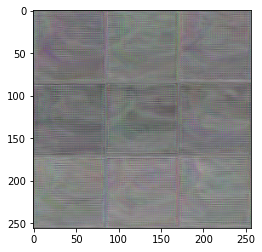

In [156]:
plt.imshow(sr1)